In [2]:
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
!pip install logomaker


def summarize_seqs(design_dir):
    out_df = pd.DataFrame()
    
    for path in glob.glob(design_dir+'/*_rosetta.pdb_/aa.csv'):
        pdb_id = path.split('/')[-2]
        df = pd.read_csv(path)
        # append df to out_df
        # out_df = out_df.append(df)

        aar = df['AAR'].mean()
        ppl = df['PPL'].mean()
        aa = df['sampled_aa'].iloc[0]
        out_df = out_df.append({'pdb_id': pdb_id, 'AAR': aar, 'PPL': ppl, 'AA':aa}, ignore_index=True)
    out_df.to_csv(design_dir+'/summary.csv', index=False)
    return out_df

def plot_logo(aas):
    import logomaker
    # create a Logo object
    counts_mat = logomaker.alignment_to_matrix(aas)
    logomaker.Logo(counts_mat)
    return counts_mat






In [3]:
seq_design_dir = 'results/seq_design_fixed_pos/mutation/CDRH3_7_9/seq_design'
seq_design_df = summarize_seqs(seq_design_dir)
seq_design_df.sort_values(by='AAR', ascending=True).head()
seq_design_df['id'] = seq_design_df['pdb_id'].apply(lambda x: x.split('_')[0])

print(seq_design_df.head())
print(seq_design_df.shape)

OSError: Cannot save file into a non-existent directory: 'results/seq_design_fixed_pos/mutation/CDRH3_7_9/seq_design'

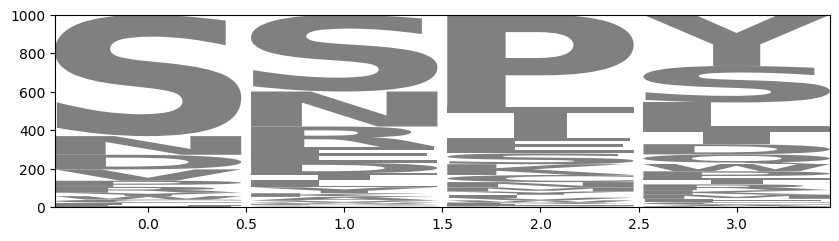

In [226]:
# mutation_position = [103,104,105, 106]
design_aa_counts = plot_logo(seq_design_df['AA'])

In [4]:
ddg_summary = pd.read_csv('results/dock_cdr/7bsd_A_B_G.pdb_/summary.csv')
ddg_summary['id'] = ddg_summary['filename'].apply(lambda x: x.split('_')[0])
ddg_summary[ddg_summary['ddG']<0].head()

FileNotFoundError: [Errno 2] No such file or directory: 'results/dock_cdr/7bsd_A_B_G.pdb_/summary.csv'

In [235]:
screen_dir = 'results/screening/mutation_fixed_pos/mutation/CDRH3_7_9/dock_design_single/'

screening_df = pd.DataFrame()
for result_path,seq_path in zip(
    glob.glob(f'{screen_dir}/*/results.csv'),
    glob.glob(f'{screen_dir}/*/aa.csv')
):
    pdb_id = result_path.split('/')[-2]
    df = pd.read_csv(result_path)
    seq_df = pd.read_csv(seq_path)
    aa = seq_df['sampled_aa'].iloc[0]
    dockq_list = eval(df['DockQ'].iloc[0])
    prmsd_list = eval(df['prmsd'].iloc[0])
    screening_df = screening_df.append({
        'id': pdb_id.split('_')[0],
        'aa': aa,
        'DockQ_avg': np.mean(dockq_list),
        'prmsd_avg': np.mean(prmsd_list),
        'DockQ_std': np.std(dockq_list),
        'prmsd_std': np.std(prmsd_list),
    }, ignore_index=True)

screening_df.head()

,id,aa,DockQ_avg,prmsd_avg,DockQ_std,prmsd_std
0,0585,FYYYTSSTSVY,0.33871,1.159995,0.126217,0.048978
1,0614,FYYYTVSPVVY,0.37527,1.221630,0.123623,0.049770
2,0985,FYYYTNAPPVY,0.33593,1.238644,0.116762,0.067353
3,0622,FYYYTVNPQVY,0.42993,1.186780,0.095651,0.033794
4,0341,FYYYTSSPDVY,0.32451,1.340458,0.158890,0.123519


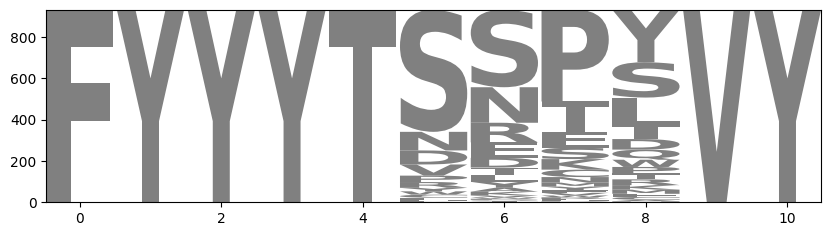

In [236]:
aa_counts = plot_logo(screening_df['aa'])

In [238]:
metric_df = screening_df.merge(ddg_summary[['id', 'ddG']], how='left', left_on='id', right_on='id')
metric_df = metric_df.merge(seq_design_df[['id', 'AAR', 'lm_score_avg', 'lm_score_std']], how='left', left_on='id', right_on='id')
quantiles = metric_df.quantile([0.75, 0.5,  0.25])

# Filter out top 30% of samples in DockQ_std and prmsd_std
filtered_df = metric_df[(metric_df['DockQ_std'] <= quantiles.loc[0.5, 'DockQ_std']) &
                        (metric_df['prmsd_std'] <= quantiles.loc[0.5, 'prmsd_std'])&
                        # (metric_df['DockQ_avg'] >= quantiles.loc[0.5, 'DockQ_avg'])&
                        (metric_df['prmsd_avg'] <= quantiles.loc[0.5, 'prmsd_avg'])&
                        (metric_df['ddG'] < 0) &
                        (metric_df['lm_score_avg'] >= lm_score_cutoff) 
                        ]
print(filtered_df.shape)

(21, 10)


In [241]:
filtered_df.to_csv('mutation_four_points.csv', index=False,float_format='%.3f')

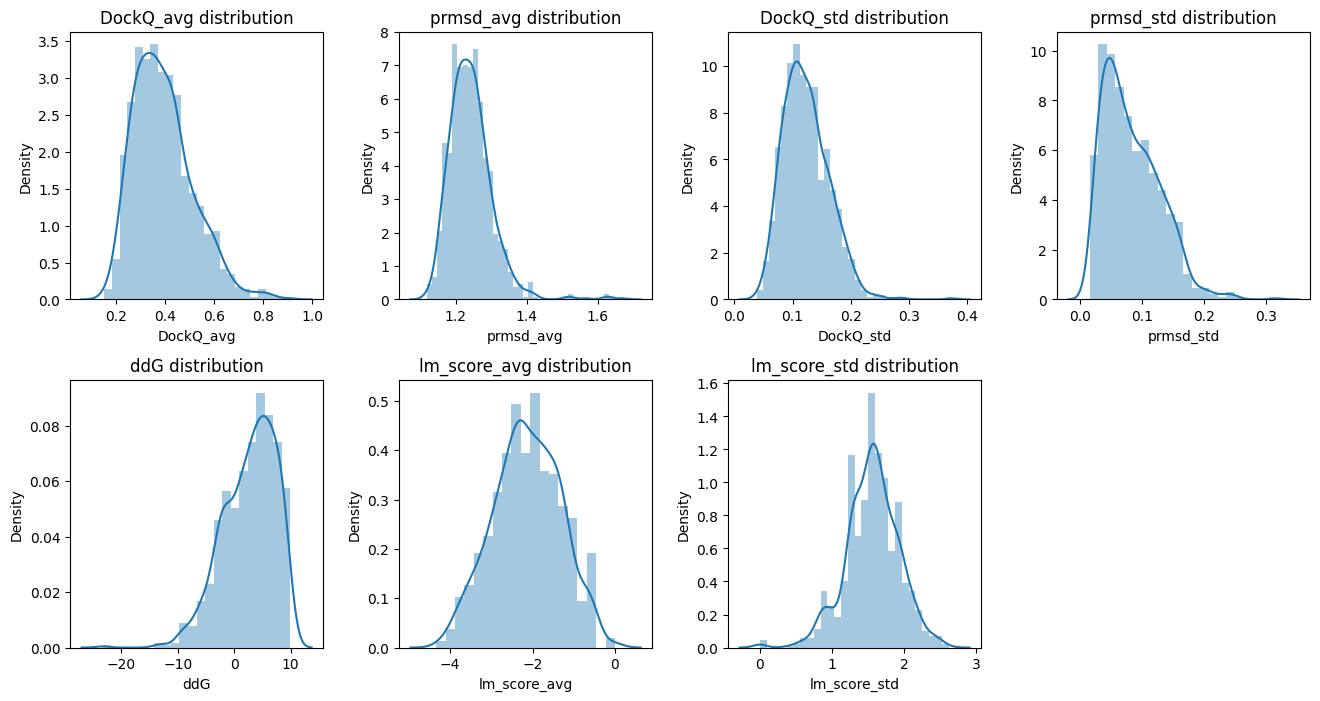

In [240]:
# create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# plot the distributions of each column in a separate subplot
sns.distplot(metric_df['DockQ_avg'], ax=axes[0, 0])
sns.distplot(metric_df['prmsd_avg'], ax=axes[0, 1])
sns.distplot(metric_df['DockQ_std'], ax=axes[0, 2])
sns.distplot(metric_df['prmsd_std'], ax=axes[0, 3])
sns.distplot(metric_df['ddG'][metric_df['ddG'] < 10], ax=axes[1, 0])
axes[1, 3].remove()  # remove the empty subplot

# set the titles and labels of each subplot
axes[0, 0].set(title='DockQ_avg distribution', xlabel='DockQ_avg')
axes[0, 1].set(title='prmsd_avg distribution', xlabel='prmsd_avg')
axes[0, 2].set(title='DockQ_std distribution', xlabel='DockQ_std')
axes[0, 3].set(title='prmsd_std distribution', xlabel='prmsd_std')
axes[1, 0].set(title='ddG distribution', xlabel='ddG')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()